## Семинар 1 "Полносвязные нейронные сети"

ФИО: Елохов Артур Владимирович

В этом задании вам предстоит реализовать проход "вперед" для полносвязной нейронную сети. В дальнейшем мы реализуем процедуру обучения и научим сеть распознавать рукописные цифры.

На первой лекции мы познакомились с тем, что такое нейронные сети и изучили три слоя — линейный, сигмоида и SoftMax. Из этих слоев можно составлять глубокие архитектуры и обучать их при помощи градиентного спуска. Чтобы конструировать сложные архитектуры, можно реализовать каждый тип слоя как отдельный "кирпичик" и затем собирать полную архитектуру как конструктор. Это мы и попробуем сделать на первом и втором семинарах.

Каждый тип слоя мы будем реализовывать при помощи класса, который будет поддерживать три функции: forward, которая будет применять функцию, реализуемую слоем, к входной матрице и backward, которая будет вычислять градиенты и step, которая будет обновлять веса. Чтобы не применять функцию к каждому объекту в отдельности, мы будем подавать на вход слою матрицу размера (N, d), где N — количество объектов, а d — размерность каждого объекта.

Функция forward будет вычислять по $x$ значение $y$, backward — по $\frac{\partial L}{\partial y}$ вычислять $\frac{\partial L}{\partial x}$ и обновлять внутри себя $\frac{\partial L}{\partial w}$.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (16,8)

### Часть 1: Линейный слой


In [2]:
class Linear:
    def __init__(self, input_size, output_size):
        '''
        Creates weights and biases for linear layer.
        Dimention of inputs is *input_size*, of output: *output_size*.
        '''
        #### YOUR CODE HERE
        #### Create weights, initialize them with samples from N(0, 0.1).
        loc = 0
        scale = 0.1
        W = np.random.normal(loc, scale, (input_size, output_size))
        self.W = np.concatenate((W, np.zeros((1, W.shape[1]))))
        return
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        #### YOUR CODE HERE
        #### Apply layer to input
        self.X = np.concatenate((X, -np.ones((X.shape[0],1))), axis=1)
        Y = np.dot(self.X, self.W)
        return Y
    
    def backward(self, dLdy):
        '''
        1. Compute dLdw and dLdx.
        2. Store dLdw for step() call
        3. Return dLdx
        '''
        #### YOUR CODE HERE
        dLdw = (np.dot(dLdy.T, self.X)).T
        dLdx = np.dot(dLdy, self.W.T)
        self.dLdw = dLdw
        return dLdx[:,:-1]
    
    def step(self, learning_rate):
        '''
        1. Apply gradient dLdw to network:
        w <- w - l*dLdw
        '''
        #### YOUR CODE HERE
        self.W = self.W - learning_rate * self.dLdw
        return

### Часть 2: Сигмоида

In [3]:
class Sigmoid:
    def __init__(self):
        pass
    
    def sigmoid(self, z):
        return 1.0/(1.0 + np.exp(-z))
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        #### YOUR CODE HERE
        #### Apply layer to input
        Y = self.sigmoid(X)
        self.X = X
        return Y
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        #### YOUR CODE HERE
        dydx = self.sigmoid(self.X) * (1 - self.sigmoid(self.X))
        dLdx = dLdy * dydx
        return dLdx
    
    def step(self, learning_rate):
        pass

### Часть 3: Функция потерь

Как мы увидели на семинаре, вычисление производной для связки SoftMax + Negative log-likelihood проще чем для этих двух слоев по отдельности. Поэтому мы реализуем их как один класс. Важное замечание: на проходе "вперед" важно воспользоваться трюком <a href="https://hips.seas.harvard.edu/blog/2013/01/09/computing-log-sum-exp/">log-sum-exp</a>, чтобы не столкнуться с численными неустойчивостями.

In [4]:
class NLLLoss:
    def __init__(self):
        '''
        Applies Softmax operation to inputs and computes NLL loss
        '''
        #### YOUR CODE HERE
        #### (Hint: No code is expected here, just joking)
        pass
    
    def forward(self, X, y):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        y is np.array of size (N), contains correct labels
        '''
        #### YOUR CODE HERE
        #### Apply layer to input
        N = X.shape[0]
        d = X.shape[1]
        a = np.reshape(np.max(X, axis=1), (N, 1))
        self.indicator = (np.array([ k * np.ones(N) for k in xrange(d)]) == y).astype(int).T
        L = np.sum((self.indicator * (a - X + (np.log(np.sum(np.exp(X - a), axis=1))).reshape((N, 1)))), axis=1)
        self.X = X
        self.a = a
        return np.sum(L)/N
    
    def backward(self):
        '''
        Note that here dLdy = 1 since L = y
        1. Compute dLdx
        2. Return dLdx
        '''
        #### YOUR CODE HERE
        dLdx = -1 * self.indicator + np.exp(self.X - self.a)/np.sum(np.exp(self.X - self.a), axis=1).reshape((self.X.shape[0], 1))
        return dLdx

### Часть 4, нейронная сеть

Теперь, когда у нас есть "кирпичики", мы можем написать класс, который будет собирать всю сеть вместе 

In [5]:
class NeuralNetwork:
    def __init__(self, modules):
        '''
        Constructs network with *modules* as its layers
        '''
        #### YOUR CODE HERE
        self.modules = modules
        self.Loss = NLLLoss()
        return
    
    def forward(self, X):
        #### YOUR CODE HERE
        #### Apply layers to input
        for module in self.modules:
            X = module.forward(X)
        return X
    
    def backward(self, dLdy):
        '''
        dLdy here is a gradient from loss function
        '''
        #### YOUR CODE HERE
        for module in reversed(self.modules):
            dLdy = module.backward(dLdy)
        return dLdy
    
    def step(self, learning_rate):
        for module in self.modules:
            module.step(learning_rate)
        return
    
    def train(self, X, y, Epoch=100, learning_rate=0.01):
        self.Loss_train = []
        for epoch in xrange(Epoch):
            result = self.forward(X)
            loss = self.Loss.forward(result, y)
            if(epoch % 100 == 99):
                print "Epoch: %d; Loss: %f" %(epoch, loss)
            self.Loss_train.append(loss)
            self.backward(self.Loss.backward())
            self.step(learning_rate)  
        return np.argmax(result, axis=1)
    
    def predict(self, X):
        return np.argmax(self.forward(X), axis=1)
    
    def loss_plot(self, Epoch):
        axis_x = np.arange(0, Epoch)
        axis_y = np.array(self.Loss_train)
        plt.figure()
        plt.plot(axis_x, axis_y)
        plt.xlabel('Epoch')
        plt.ylabel('NLL')
        plt.show()
        return

### Часть 5, обучение на простых данных

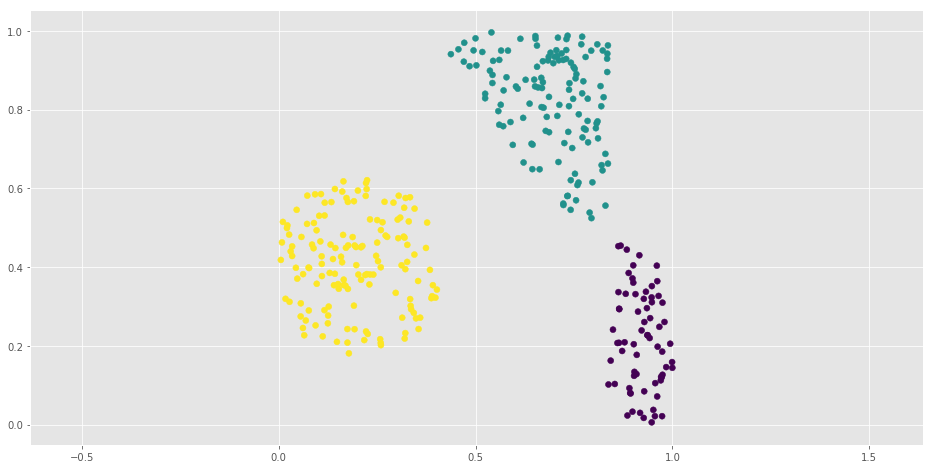

In [6]:
data = np.load('data.npz')
X, y = data['arr_0'], data['arr_1']
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.axis('equal')
plt.show()

Обучите архитектуру вида 2 -> 10 -> 10 -> 3:
* Linear(2, 10)
* Sigmoid()
* Linear(10, 10)
* Sigmoid()
* Linear(10, 3)

В качестве функции потерь используйте NLLLoss.
1. Создайте сеть, в цикле запускайте forward, backward, step (используйте learning rate 0.01). 
2. Нарисуйте график сходимости (изменение NLL со временем).
3. Нарисуйте разделяющую поверхность

Отличная визуализация: http://playground.tensorflow.org/

In [7]:
### YOUR CODE HERE:
Clf = NeuralNetwork((Linear(2, 10), Sigmoid(), Linear(10, 10), Sigmoid(), Linear(10, 3)))
Epoch = 500
rate = 0.01
result = Clf.train(X, y, Epoch, rate)

Epoch: 99; Loss: 0.611807
Epoch: 199; Loss: 0.187937
Epoch: 299; Loss: 0.050523
Epoch: 399; Loss: 0.012276
Epoch: 499; Loss: 0.006406


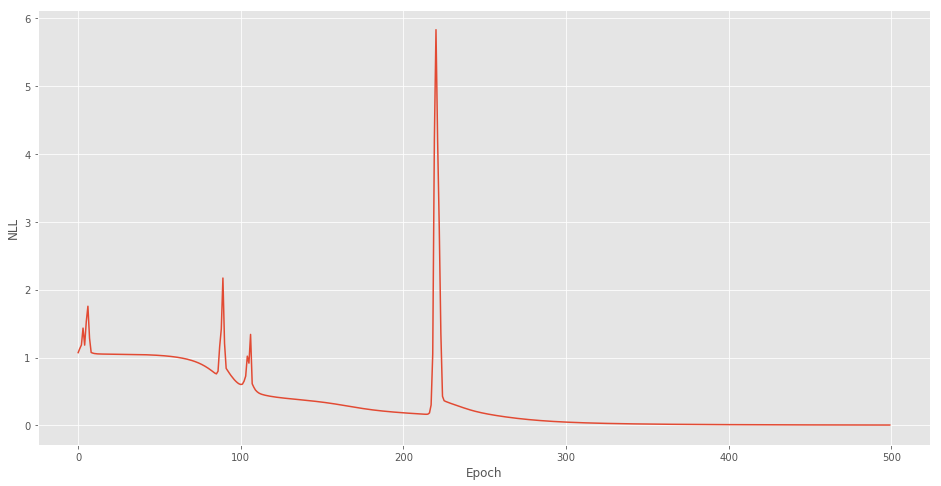

In [8]:
Clf.loss_plot(Epoch)

In [9]:
def decision_boundary(X, y, Clf, h=0.01):
    x1_min, x1_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    x2_min, x2_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    x1, x2 = np.meshgrid(np.arange(x1_min, x1_max, h), np.arange(x2_min, x2_max, h))
    mesh = np.c_[x1.ravel(), x2.ravel()]
    for epoch in xrange(Epoch):
        result = Clf.forward(mesh)
    Z = np.argmax(result, axis=1)
    Z = Z.reshape(x1.shape)
    plt.contourf(x1, x2, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y)

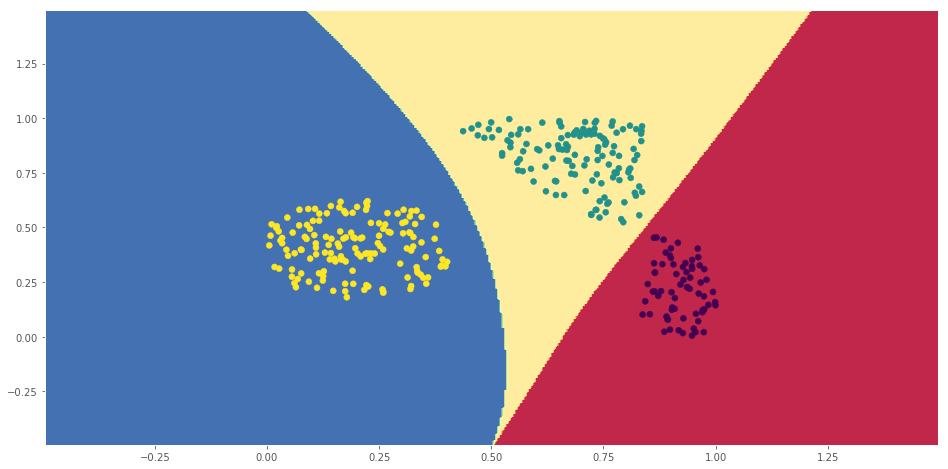

In [10]:
decision_boundary(X, y, Clf, 0.005)